In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import itertools
import copy

In [ ]:
transformers = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # mean imagenet
                         [0.229, 0.224, 0.225]) # std imagenet
])

In [ ]:
dataset_name = "prostate_cancer"
#dataset_name = "animal_faces"
#model_from = "task1"
model_from = "pretrained"
#dataset_url = "Dataset/Dataset_3/Animal_Faces"
dataset_url = "Dataset/Dataset_2/Prostate_Cancer"

In [ ]:
dataset = datasets.ImageFolder(root = ("/content/drive/MyDrive/MLProject/Data/"+dataset_url),
transform = transformers)

In [ ]:
class_to_idx = dataset.class_to_idx
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

In [ ]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: /content/drive/MyDrive/MLProject/Data/Dataset/Dataset_2/Prostate_Cancer
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
if model_from == "task1":
  loaded_model = torch.load("/content/drive/MyDrive/MLProject/Data/Model/model_pretrained_approach1_001_32_all.pt")
else:
  loaded_model = model_resnet18_pretrained = models.resnet18(weights='IMAGENET1K_V1')
device = "cuda:0" # use 'cuda:0' to speed it up.

In [ ]:
resnet18_without_fc = torch.nn.Sequential(*list(loaded_model.children())[:-1])
resnet18_without_fc

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
batch_size = 32

data_loader = DataLoader(dataset, shuffle=True, batch_size = batch_size, pin_memory = True) # create train loader
resnet18_without_fc.to(device)
resnet18_without_fc.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Initialize lists to store predicted labels and ground truth labels
extracted_features = []
class_labels = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        features = resnet18_without_fc(inputs)
        features = features.view(features.size(0), -1)

        class_labels.extend(labels.tolist())
        extracted_features.append(features)

extracted_features = torch.cat(extracted_features, dim=0)

In [ ]:
features_labels = pd.DataFrame(extracted_features.cpu().numpy())
features_labels["labels"] = [idx_to_class[label] for label in class_labels]

In [ ]:
print(features_labels.shape);
print(features_labels.head);

(6000, 513)
<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0     2.729229  0.762730  1.249546  2.702517  1.007057  0.632410  0.123262   
1     2.829426  1.133366  0.546826  3.547064  0.639775  0.193599  0.114327   
2     2.024790  2.340823  1.006985  1.607782  1.014210  1.210234  0.479635   
3     1.081179  1.971848  0.391018  1.223169  0.899337  0.447762  0.429179   
4     0.864898  1.107793  0.412470  2.849890  0.452426  0.749621  0.084461   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.327552  0.641105  0.632431  2.351687  1.303874  0.310201  0.451759   
5996  0.098828  0.375427  1.234963  0.137101  1.121400  0.393852  0.913590   
5997  3.413352  0.137775  0.000000  4.704021  0.949208  0.350900  1.141441   
5998  0.265204  1.079743  1.127727  2.241136  1.419541  0.442526  0.562279   
5999  0.655815  0.562465  0.574036  0.437508  3.059108  0.991759  0.040628   

             7       

In [ ]:
features_labels.to_csv("/content/drive/MyDrive/MLProject/Data/Task2/Features/features_labels_"+model_from+"_model_"+dataset_name+".csv",index=False)

In [ ]:
from sklearn.manifold import TSNE

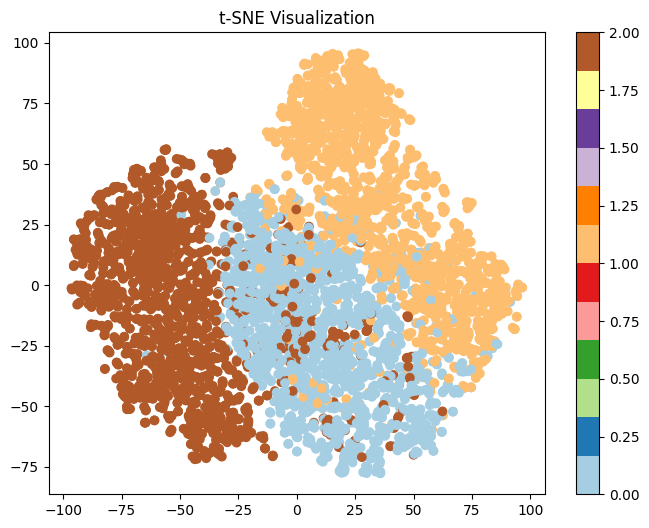

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
X_tsne = tsne.fit_transform(extracted_features.cpu().numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=class_labels, cmap=plt.cm.Paired)

# Define class labels and colors
class_colors = [scatter.to_rgba(i) for i in range(len(class_labels))]

# Create legend handles
#legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(class_labels, class_colors)]

# Add legend
#plt.legend(handles=legend_handles, title="Classes", loc='best')

plt.title("t-SNE Visualization")
plt.colorbar()
plt.show()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLProject/Data/Task2/Features/features_labels_"+model_from+"_model_"+dataset_name+".csv")
print(df.shape)

(6000, 513)


In [ ]:
df.head

<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0     2.729229  0.762730  1.249546  2.702517  1.007057  0.632410  0.123262   
1     2.829426  1.133366  0.546826  3.547064  0.639775  0.193599  0.114327   
2     2.024790  2.340823  1.006985  1.607782  1.014209  1.210234  0.479635   
3     1.081179  1.971847  0.391018  1.223169  0.899337  0.447762  0.429179   
4     0.864898  1.107793  0.412470  2.849890  0.452426  0.749621  0.084461   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.327552  0.641105  0.632431  2.351687  1.303874  0.310201  0.451759   
5996  0.098828  0.375427  1.234963  0.137101  1.121400  0.393852  0.913590   
5997  3.413352  0.137775  0.000000  4.704021  0.949208  0.350900  1.141441   
5998  0.265204  1.079743  1.127727  2.241136  1.419541  0.442526  0.562279   
5999  0.655815  0.562465  0.574036  0.437508  3.059108  0.991760  0.040628   

             7         8         

In [ ]:
value_counts = df['labels'].value_counts()
print(value_counts)

nongland    2000
gland       2000
tumor       2000
Name: labels, dtype: int64
